#Contexto

La inteligencia artificial y el aprendizaje automático están revolucionando la industria de la manufactura. En este caso, se va a automatizar la detección y localización de defectos en la fabricación de acero utilizando imágenes de superficies de acero. Para ello, se utilizará la segmentación de imágenes, que permite extraer información a nivel de píxel y es útil para el reconocimiento y localización de objetos. Se empleará la arquitectura ResUNet, que codifica la imagen en un vector y luego la decodifica nuevamente en una imagen, conservando el tamaño original. La segmentación funciona como un problema de clasificación a nivel de píxel.


#IMPORTAR LIBRERÍAS Y DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
from google.colab import files
%matplotlib inline


In [ ]:
# Datos que contienen imágenes con defectos con máscara de segmentación
# Importamos el dataset

url = 'https://drive.google.com/uc?id=1u8pQ-mR-pUB_17H9xfkUKA5mBFO7_4RO'
defect_class_mask_df = pd.read_csv(url)


In [ ]:
# Datos que contienen imágenes con y sin defectos
url = 'https://drive.google.com/uc?id=1XYwDIN9_IQCj4Ph54S0cW6aV_t0TIV5g'
all_images_df = pd.read_csv(url)


In [ ]:
defect_class_mask_df  # Visualizamos el df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [ ]:
all_images_df # Visualizamos el df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


#VISUALIZAR Y EXPLORAR EL DATASET

In [ ]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)
# Agregamos una nueva columna 'mask' , se crea aplicando una función lambda a cada elemento de la columna 'ClassId'

In [ ]:
defect_class_mask_df.head(10) #Observamos los primeros 10  registros

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
5,17d02873a.jpg,3,254980 43 255236 127 255492 211 255748 253 256...,1
6,47b5ab1bd.jpg,3,128976 8 129230 12 129484 16 129739 23 129995 ...,1
7,a6ecee828.jpg,3,179011 27 179126 73 179259 39 179375 80 179497...,1
8,11aaf18e2.jpg,3,303235 2 303489 7 303743 9 303997 11 304181 2 ...,1
9,cdf669a1f.jpg,4,310246 11 310499 25 310753 28 311007 31 311262...,1


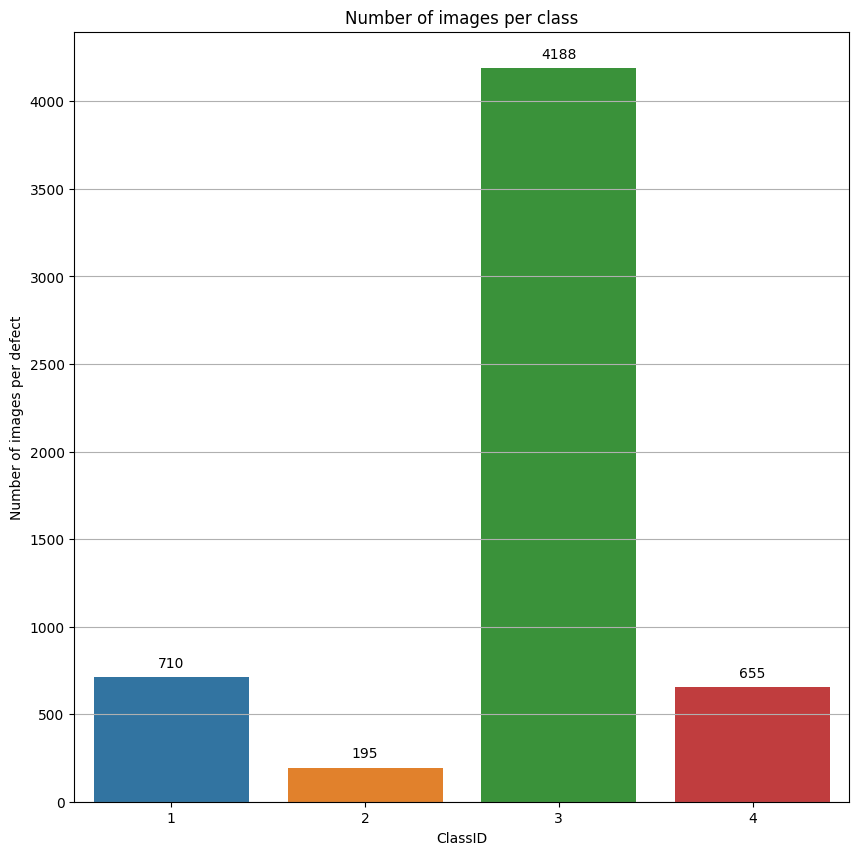

In [ ]:
plt.figure(figsize=(10,10)) # Crea una nueva figura con un tamaño específico
ax = sns.countplot(x = 'ClassId', data = defect_class_mask_df) # Crea un gráfico de barras que muestra el conteo de cada clase en 'ClassId'
plt.grid(True, axis='y')
plt.ylabel('Number of images per defect') # Establece la etiqueta del eje y
plt.xlabel('ClassID') # Establece la etiqueta del eje x
plt.title('Number of images per class') # Establece el título del gráfico

for p in ax.patches:
  ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
# Colocamos el valor correspondiente en cada barra

In [ ]:
# Algunas imágenes están clasificadas con más de un defecto, exploremos esto con más detalle

defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum() # Se agrupa el DataFrame defect_class_mask_df por la columna 'ImageId'
                                                                      # y calcula la suma de la columna 'mask' para cada grupo


In [ ]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [ ]:
defect_type.value_counts() #calcula el conteo de valores únicos

# tenemos una imagen con 3 tipos de defectos
# tenemos 272 imágenes con 2 tipos de defectos
# tenemos 5201 imágenes con 1 tipo de defecto

1    5201
2     272
3       1
Name: mask, dtype: int64

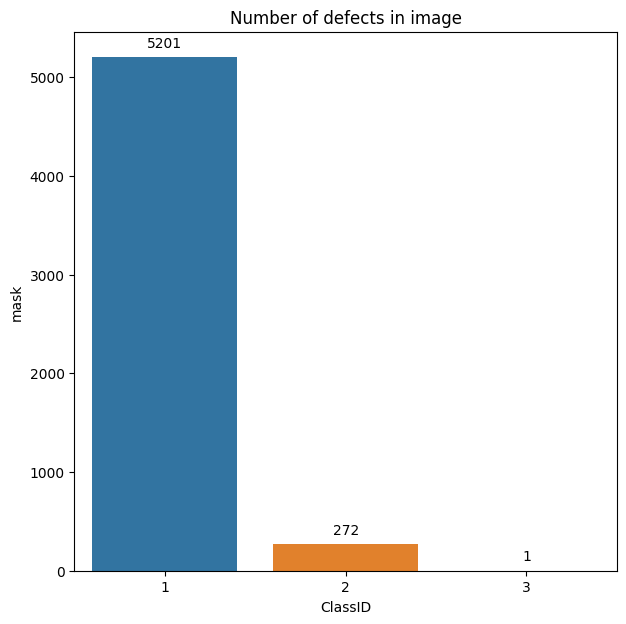

In [ ]:
# Graficamos

plt.figure(figsize=(7,7))
ax = sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
defect_class_mask_df.shape

(5748, 4)

In [ ]:
all_images_df.shape

(12997, 2)

In [ ]:
# Contemos imágenes con y sin defectos
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

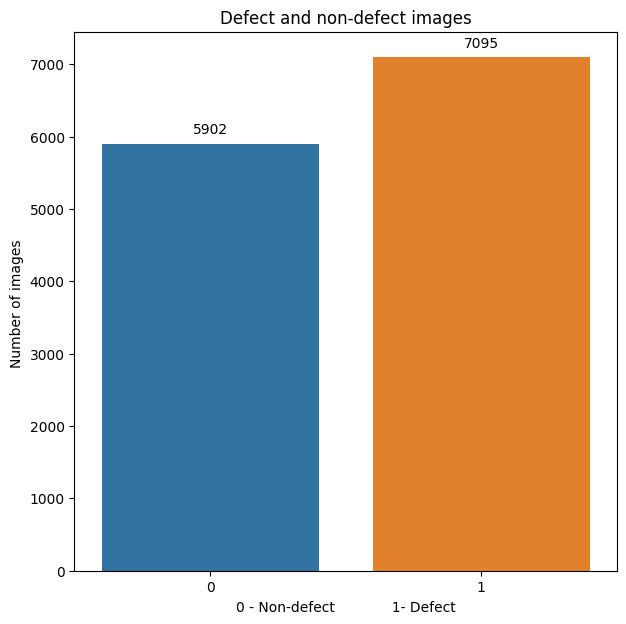

In [ ]:
#Graficamos
plt.figure(figsize=(7,7))
ax = sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect             1- Defect')
plt.title('Defect and non-defect images')

for p in ax.patches:
  ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


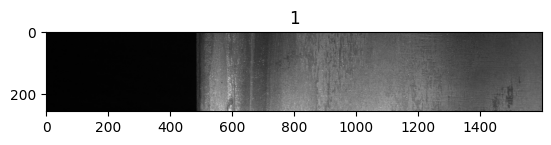

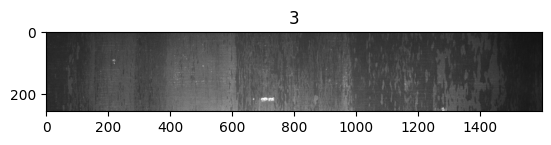

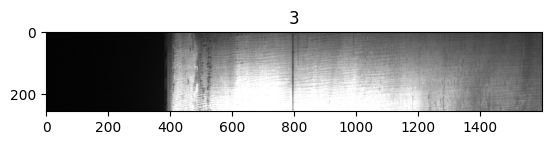

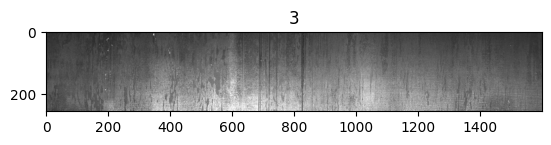

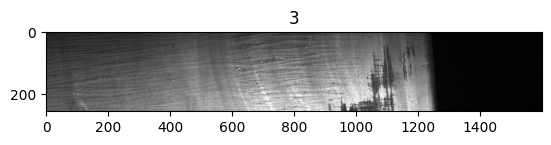

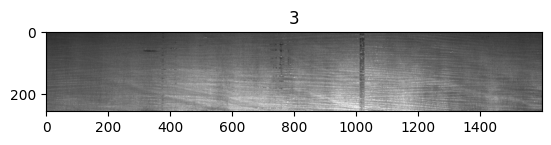

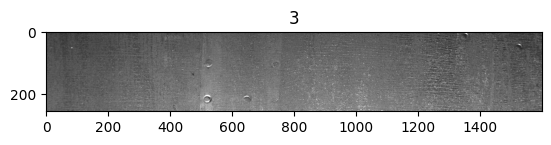

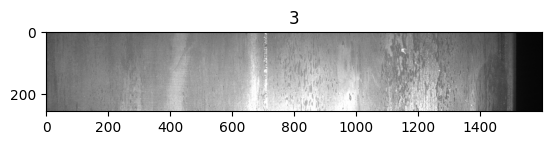

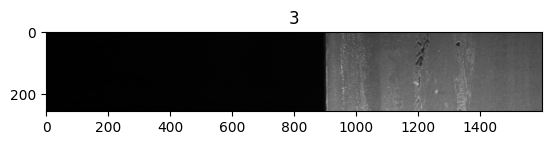

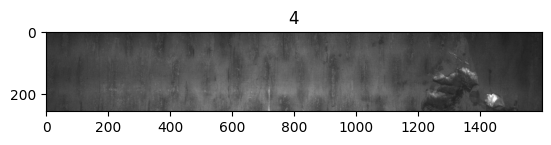

In [ ]:
# Importamos de manera local la carpeta con las imagenes
# Visualizar imágenes con defectos junto con sus etiquetas correspondientes
# Las imágenes son de 256 x 1600
from google.colab.patches import cv2_imshow
train_dir = 'Directorio local'

for i in range(10):
  # Especificar el path de las imágenes a partir de su ID de imagen
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)
# Visualizamos las 10 primeras imagenes

In [ ]:
# Previamente se creó el archivo utilities.py que contiene el código para rle2mask, mask2rle, función de pérdida personalizada y generador de datos personalizados
# dado que los datos proporcionados para la segmentación están en formato RLE (run length encoded), usaremos la siguiente función para convertir el RLE a máscara.
# podemos convertir la máscara nuevamente a RLE para evaluar el rendimiento del modelo (accuracy).
# El código fuente para estas funciones proviene de: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode

%cd /content/drive/MyDrive/Cursos/Data Scientist/Udemy/Data Science aplicado a Negocios/Data Science for Business Package/6. Producción - Fabricación - Mantenimiento/6. Maintenance Department
from utilities import rle2mask , mask2rle



/content/drive/MyDrive/Cursos/Data Scientist/Udemy/Data Science aplicado a Negocios/Data Science for Business Package/6. Producción - Fabricación - Mantenimiento/6. Maintenance Department


In [ ]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [ ]:
# Intentemos usar rle2mask en un imagen de prueba
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

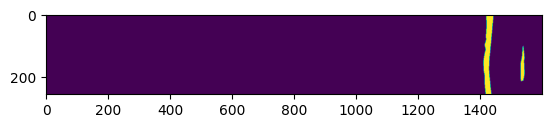

In [ ]:
# Veamos la máscara
plt.imshow(mask)

(256, 1600, 3)

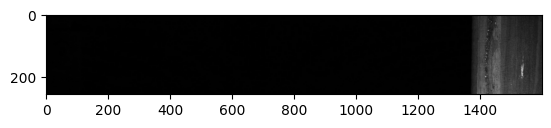

In [ ]:
# Veamos la imagen
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

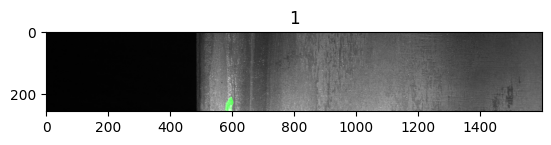

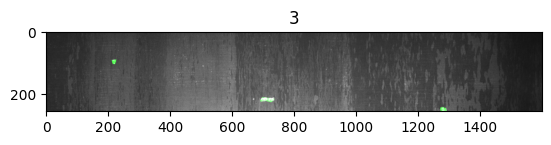

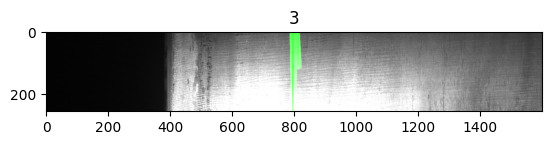

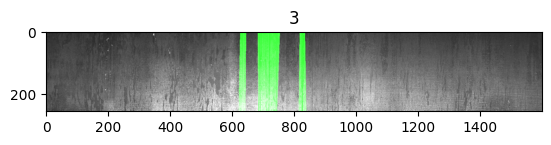

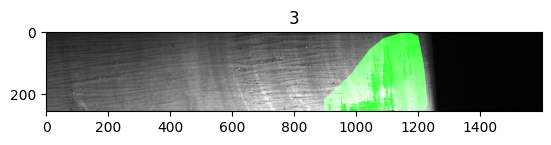

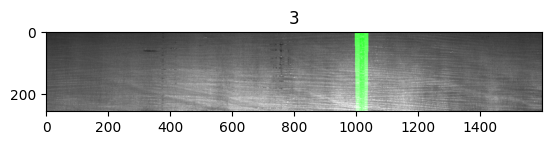

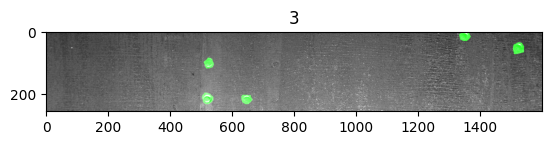

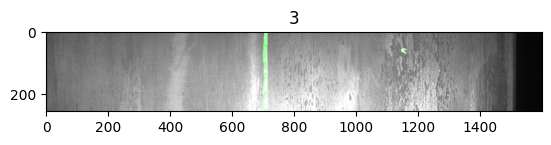

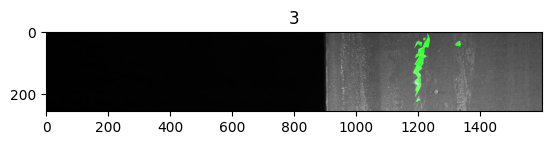

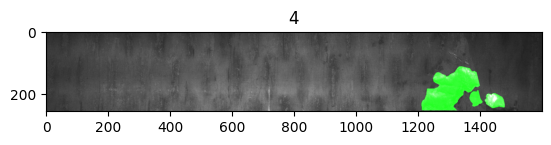

In [ ]:
for i in range(10):

  # Leer las imágenes usando opencv y convirtiéndolas al formato rgb
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # GObtener la máscara para la imagen desde rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])

  # Vamos a colorear los píxeles con valores = 1
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])


# CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING PARA DETECTAR PRESENCIA O AUSENCIA DE DEFECTO EN UNA IMAGEN

In [ ]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


In [ ]:
# Dividir el dataset (defective and non defective)  en entrenamiento y testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_images_df, test_size=0.15)

In [ ]:
train.shape

(11047, 2)

In [ ]:
test.shape

(1950, 2)

In [ ]:
# Crear un generador de imágenes para el conjunto de datos de entrenamiento y validación
# Dividiremos los datos en entrenamiento, validación y testing.
# Training = 9390
# validation = 1657
# testing = 1950

from keras.preprocessing.image import ImageDataGenerator


# Crear un generador de datos que escale los datos de 0 a 1 y hacer una división de validación de 0,15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

# crea un generador de datos de entrenamiento
train_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "training",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))

# crea un generador de datos de Validación
valid_generator = datagen.flow_from_dataframe(
dataframe = train,
directory = train_dir,
x_col = "ImageID",
y_col = "label",
subset = "validation",
batch_size = 16,
shuffle = True,
class_mode = "other",
target_size = (256, 256))


Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [ ]:
# Crear un generador de datos para imágenes de test
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
dataframe = test,
directory = train_dir,
x_col = "ImageID",
y_col = None,
batch_size = 16,
shuffle = False,
class_mode = None,
target_size = (256, 256))



Found 1950 validated image filenames.


In [ ]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))

# El modelo ResNet50 se inicializa con los pesos pre-entrenados en el conjunto de datos ImageNet utilizando el argumento weights='imagenet'.
# El argumento include_top=False indica que la capa superior completamente conectada no se incluirá en el modelo, lo que permite agregar capas personalizadas en la parte superior del modelo base.
# El argumento input_tensor=Input(shape=(256,256,3)) especifica que las imágenes de entrada tendrán un tamaño de 256x256 píxeles y 3 canales de color (RGB)

In [ ]:
basemodel.summary() #Observamos el resumen del modelo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Congelar los pesos del modelo

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

El código anterior agrega capas personalizadas en la parte superior del modelo  `basemodel`. Primero, se aplica una capa de `AveragePooling2D` con un tamaño de agrupación de 4x4. Luego, se aplana la salida utilizando una capa `Flatten`. Después, se agrega una capa `Dense` con 256 unidades y una función de activación ReLU, seguida de una capa `Dropout` con una tasa de abandono del 0.3. Finalmente, se agrega otra capa `Dense` con 1 unidad y una función de activación sigmoide. El modelo resultante se construye utilizando la entrada del modelo base y la salida de la última capa agregada.

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])  # Compilamos el modelo

In [ ]:
# Usar la parada temprana para parar el entrenamiento si la pérdida en validación no baja después de un cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
# Entrenamos el modelo
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator,
                              validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

<ipython-input-39-b51609a7496f>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator,


Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7523
Epoch 1: val_loss improved from inf to 1.88408, saving model to resnet-weights.hdf5
586/586 [==============================] - 1356s 2s/step - loss: 0.5504 - accuracy: 0.7523 - val_loss: 1.8841 - val_accuracy: 0.4381
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8200
Epoch 2: val_loss improved from 1.88408 to 1.70321, saving model to resnet-weights.hdf5
586/586 [==============================] - 179s 305ms/step - loss: 0.3947 - accuracy: 0.8200 - val_loss: 1.7032 - val_accuracy: 0.6365
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8491
Epoch 3: val_loss did not improve from 1.70321
586/586 [==============================] - 171s 291ms/step - loss: 0.3432 - accuracy: 0.8491 - val_loss: 2.0243 - val_accuracy: 0.4769
Epoch 4/40
586/586 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0

In [ ]:
# Guardamos la arquitectura del modelo entrenado para el futuro

model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

#EVALUAR LA EFICACIA DEL MODELO

In [ ]:
with open('resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargamos el modelo
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción

from keras_preprocessing.image import ImageDataGenerator

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)


121/121 [==============================] - 22s 183ms/step


In [ ]:
test_predict # Observamos el resultado

array([[4.9002608e-12],
       [1.0891805e-09],
       [9.9976248e-01],
       ...,
       [9.9999952e-01],
       [9.9059874e-01],
       [8.3911499e-07]], dtype=float32)

In [ ]:
# Dado que usamos la función de activación sigmoidea al final, nuestro resultado contiene valores continuos de 0 a 1.
# La red se usa inicialmente para clasificar si la imagen tiene defecto o no
# Luego, estas imágenes (defectuosas) se pasan por la red de segmentación para obtener la ubicación y el tipo de defecto.
# Vamos a elegir 0.01, para asegurarnos de que omitimos las imágenes para que no pasen por la red de segmentación a menos que
# estemos muy seguros de que no tiene ningún defecto y si no estamos seguros, podemos pasar esta imagen a través de la red de segmentación.

predict = []

for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)

predict = np.asarray(predict)

In [ ]:
len(predict)

1936

In [ ]:
# como usamos el generador de prueba, limito las imágenes a 1936, debido al tamaño del lote

original = np.asarray(test.label)[:1936]
len(original)

1936

In [ ]:
# Buscamos la accuracy del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8734504132231405

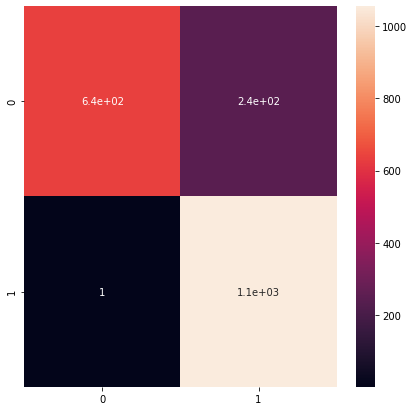

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [ ]:
# Imprimimos el reporte de clasificación

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       880
           1       0.81      1.00      0.90      1056

    accuracy                           0.87      1936
   macro avg       0.91      0.86      0.87      1936
weighted avg       0.90      0.87      0.87      1936



## Ánalisis del resultado
La precisión para la clase 0 es 1.00, lo que significa que cuando el modelo predice la clase 0, siempre acierta. Sin embargo, el recall para la clase 0 es 0.72, lo que significa que el modelo solo identifica correctamente el 72% de los casos verdaderos de la clase 0.

Para la clase 1, la precisión es 0.81, lo que significa que cuando el modelo predice la clase 1, acierta en el 81% de los casos. El recall para la clase 1 es 1.00, lo que significa que el modelo identifica correctamente todos los casos verdaderos de la clase 1.

Un puntaje F1 alto indica un buen equilibrio entre precisión y recall. En este caso, el puntaje F1 para la clase 0 es 0.84 y para la clase 1 es 0.90.

La precisión general del modelo (exactitud) es del 87%, lo que significa que el modelo predice correctamente el 87% de los casos en total.

En resumen, este informe muestra que el modelo tiene un buen rendimiento en general, sin dejar a un lado que puede mejorar.

#CONSTRUIR UN MODELO DE SEGMENTACIÓN CON RESUNET

In [ ]:
# dividir los datos en datos de entrenamiento y de prueba

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

In [ ]:
# crear una lista separada para imageId, classId y rle para pasar al generador

train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [ ]:
from utilities import DataGenerator

# Crear el generador de imágenes
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)


/content/drive/MyDrive/Cursos/Data Scientist/Udemy/Data Science aplicado a Negocios/Data Science for Business Package/6. Producción - Fabricación - Mantenimiento/6. Maintenance Department


In [ ]:
def resblock(X, f):
  # Hacemos una copia de la entrada
  X_copy = X

  # Path principal
  # Primera capa convolucional con tamaño de kernel (1,1) y stride (1,1)
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
  # Normalización por lotes
  X = BatchNormalization()(X)
  # Función de activación ReLU
  X = Activation('relu')(X)

  # Segunda capa convolucional con tamaño de kernel (3,3), stride (1,1) y padding 'same'
  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  # Normalización por lotes
  X = BatchNormalization()(X)

  # Path corto
  # Capa convolucional con tamaño de kernel (1,1) y stride (1,1)
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  # Normalización por lotes
  X_copy = BatchNormalization()(X_copy)

  # Añadimos el fichero de salida a partir de la combinación de path principal y el corto
  # Sumamos las salidas del path principal y el corto
  X = Add()([X,X_copy])
  # Función de activación ReLU
  X = Activation('relu')(X)

  return X


 La función implementa un bloque residual que consta de dos capas convolucionales en el camino principal y una capa convolucional en el camino corto. Las salidas de ambos caminos se suman y se pasa a través de una función de activación ReLU antes de devolver el resultado. Los bloques residuales son útiles para entrenar redes neuronales profundas ya que ayudan a mitigar el problema del desvanecimiento del gradiente.

In [ ]:
# Función para upscale y concatenar los valores

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)  # Aumento de escala en el tensor 'x' con un factor de escala de (2,2)
  merge = Concatenate()([x, skip])  # Concatenación del tensor aumentado con el tensor 'skip' a lo largo del último eje

  return merge

Esta función aumenta la escala de un tensor y lo concatena con otro tensor. Esta operación es común en las redes neuronales convolucionales para aumentar la resolución espacial de las características extraídas por las capas convolucionales.

In [ ]:
# Definimos la forma de entrada
input_shape = (256,256,1)

# Tensor de entrada
X_input = Input(input_shape)

# Etapa 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Etapa 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Etapa 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Etapa 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Etapa 5
conv5_in = resblock(pool_4, 256)

# Etapa de aumento de escala 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Etapa de aumento de escala 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Etapa de aumento de escala 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Etapa de aumento de escala 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida final
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )  # Creación del modelo de Keras utilizando la API funcional


## Función de pérdidas:

Necesitamos una función de pérdida personalizada para entrenar a este ResUNet: https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


In [ ]:
#Importamos las librerias prediseñadas

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Creación del optimizador Adam con una tasa de aprendizaje de 0.05 y un valor de épsilon de 0.1
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)

# Compilación del modelo 'model_seg' utilizando el optimizador Adam y la función de pérdida 'focal_tversky'
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])


In [ ]:
# usar la parada temprana para salir del entrenamiento si la pérdida de validación no disminuye incluso después de ciertas epochs
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# guardar el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

Epoch 1/40
287/287 [==============================] - ETA: 0s - loss: 0.9339 - tversky: 0.0869
Epoch 00001: val_loss improved from inf to 0.87792, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 123s 430ms/step - loss: 0.9339 - tversky: 0.0869 - val_loss: 0.8779 - val_tversky: 0.1590
Epoch 2/40
287/287 [==============================] - ETA: 0s - loss: 0.7274 - tversky: 0.3430
Epoch 00002: val_loss improved from 0.87792 to 0.66480, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 119s 415ms/step - loss: 0.7274 - tversky: 0.3430 - val_loss: 0.6648 - val_tversky: 0.4178
Epoch 3/40
287/287 [==============================] - ETA: 0s - loss: 0.6317 - tversky: 0.4560
Epoch 00003: val_loss improved from 0.66480 to 0.60222, saving model to resunet-segmentation-weights.hdf5
287/287 [==============================] - 118s 411ms/step - loss: 0.6317 - tversky: 0.4560 - val_loss: 0.6022 - val_tversky: 0.4898
Ep

KeyboardInterrupt: ignored

In [ ]:
# Guardamos el modelo para uso futuro

model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

# EVALUAR LA EFICACIA DEL MODELO DE SEGMENTACIÓN ENTRENADO

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

# Leer el archivo JSON que contiene el modelo guardado
with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Cargar el modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')  # Cargar los pesos del modelo desde un archivo HDF5
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1) # Crear el optimizador Adam con una tasa de aprendizaje de 0.05 y un valor de épsilon de 0.1
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])  # Compilar el modelo utilizando el optimizador Adam y la función de pérdida 'focal_tversky'


In [ ]:
# Cargamos los datos del conjunto de test para la tarea de segmentación

test_df = pd.read_csv('test.csv')


In [ ]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [ ]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [ ]:
from utilities import prediction

# Hacemos la predicción
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


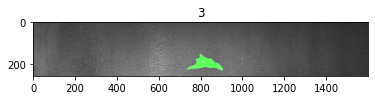

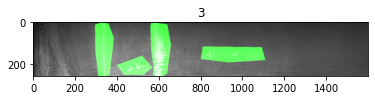

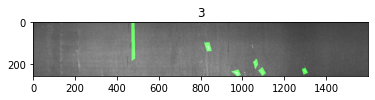

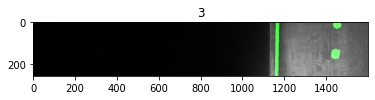

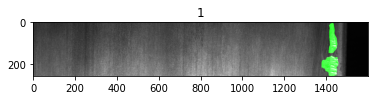

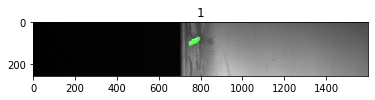

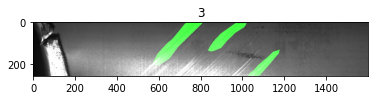

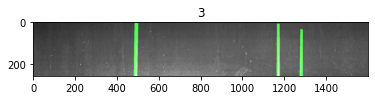

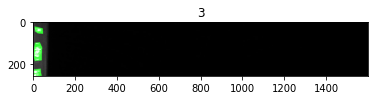

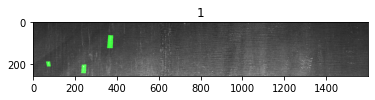

In [ ]:
# Vamos a mostrar las imágenes junto con sus máscaras originales (ground truth)
for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Obtener máscara para la imagen de rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

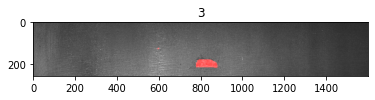

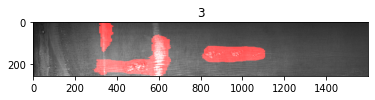

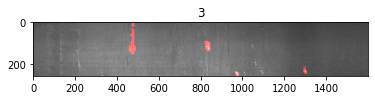

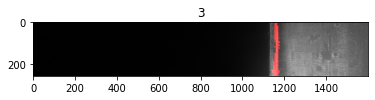

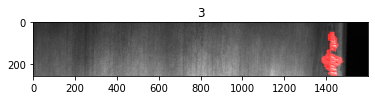

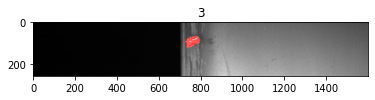

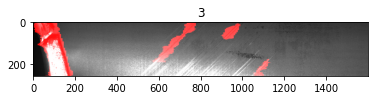

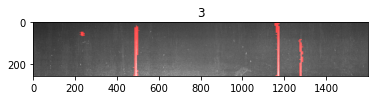

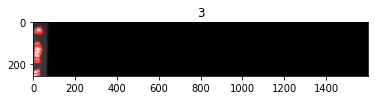

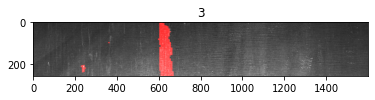

In [ ]:
# visualizar los resultados (predicciones del modelo)

directory = "train_images"

for i in range(10):

  # leer las imágenes usando opencv y convertirlas a formato rgb
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

   # Obtener máscara para la imagen de rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)

##Resumen

Se logró enmascarar con éxito las fallas visibles en las imágenes utilizando un modelo de segmentación. Esto permitió detectar de manera efectiva las fallas en los materiales, lo que representa un avance importante en la capacidad de identificar y solucionar problemas en los materiales. El modelo de segmentación se construyó utilizando una red neuronal convolucional y se entrenó con datos etiquetados para aprender a identificar las fallas en las imágenes. Una vez entrenado, el modelo se utilizó para enmascarar las fallas en nuevas imágenes y así facilitar su detección. En resumen, el uso de técnicas de aprendizaje profundo permitió mejorar la capacidad de detectar fallas en los materiales a partir de imágenes.